# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
!pip install smdebug

In [3]:
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
# Hyper parameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

* The dataset contains 133 sub-classes
* Each class has diiferent image of dogs
* The dataset is divided into 3 categories- Test, Valid, Train.

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

### Upload data to S3

In [5]:
# Upload metadata
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = 'Project/dog-breed-dataset'
# ---
DATASET_LOCAL_DIR = "dogImages"

In [6]:
dataset_dir_path = sagemaker_session.upload_data(
    path=DATASET_LOCAL_DIR,
    bucket=BUCKET,
    key_prefix=PREFIX
)

print(f"Dataset directory path on S3 : {dataset_dir_path}")

Dataset directory path on S3 : s3://sagemaker-us-east-1-650457939524/Project/dog-breed-dataset


### Data Exploration

,# train,# valid,# test
Dog Breed,,,
001.Affenpinscher,64,8,8
002.Afghan_hound,58,7,8
003.Airedale_terrier,52,7,6
004.Akita,63,8,8
005.Alaskan_malamute,77,9,10
...,...,...,...
129.Tibetan_mastiff,48,6,6
130.Welsh_springer_spaniel,44,6,5
131.Wirehaired_pointing_griffon,30,4,3



--- Distribution ---

          # train     # valid      # test
count  133.000000  133.000000  133.000000
mean    50.225564    6.278195    6.285714
std     11.863885    1.350384    1.712571
min     26.000000    4.000000    3.000000
25%     42.000000    6.000000    5.000000
50%     50.000000    6.000000    6.000000
75%     61.000000    7.000000    8.000000
max     77.000000    9.000000   10.000000

 --- Split distribution ---


array([[<AxesSubplot:title={'center':'# train'}>,
        <AxesSubplot:title={'center':'# valid'}>],
       [<AxesSubplot:title={'center':'# test'}>, <AxesSubplot:>]],
      dtype=object)

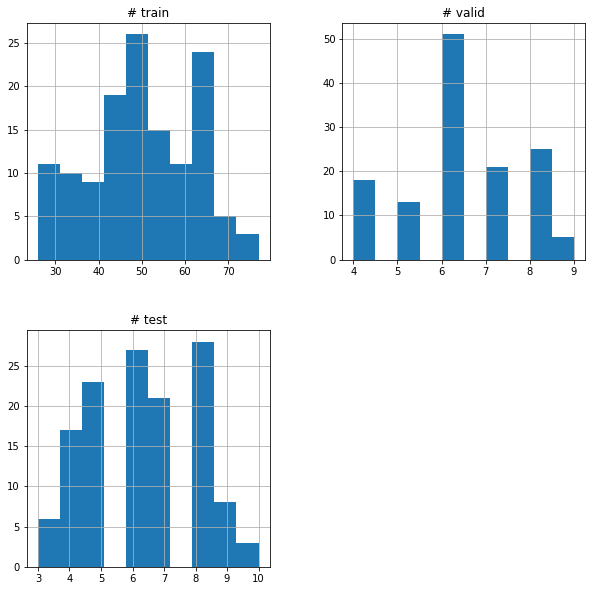

In [7]:
classes = sorted(os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train')))
num_train_images = []
num_valid_images = []
num_test_images = []

for _class in classes:
    num_train_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train', _class))]))
    num_valid_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'valid', _class))]))
    num_test_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'test', _class))]))

df_stats = pd.DataFrame(
    {
        "Dog Breed" : list(classes),
        "# train" : num_train_images,
        "# valid" : num_valid_images,
        "# test"  : num_test_images
    }
)
df_stats = df_stats.set_index("Dog Breed")

display(df_stats)

print("\n--- Distribution ---\n")
print(df_stats.describe())

print("\n --- Split distribution ---")
display(df_stats.hist(figsize=(10, 10)))

##### From the EDA we understand :
    * The Train dataset has 50 images of each class
    * The test and valid dataset has about 6 images of each class
    * Some of the images are not of the same size
    * Some images are too big.

In [8]:
dataset_dir_path = 's3://sagemaker-us-east-1-650457939524/Project/dog-breed-dataset/'
role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2])
}

In [10]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [11]:
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd,  "hpo.py"),
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=2,
    instance_type="ml.c5.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [12]:
tuner.fit({'data': dataset_dir_path}, wait=True) # TODO: Remember to include your data channels

......................................................................................................................................................................................................................................................!


In [13]:
best_estimator = tuner.best_estimator()

best_estimator_hyperparameters=best_estimator.hyperparameters()
print(best_estimator_hyperparameters)


2023-09-14 08:57:28 Starting - Preparing the instances for training
2023-09-14 08:57:28 Downloading - Downloading input data
2023-09-14 08:57:28 Training - Training image download completed. Training in progress.
2023-09-14 08:57:28 Uploading - Uploading generated training model
2023-09-14 08:57:28 Completed - Resource released due to keep alive period expiry
{'_tuning_objective_metric': '"average test loss"', 'batch-size': '"32"', 'epochs': '"1"', 'lr': '0.0011115480428086704', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-09-14-08-45-06-877"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-650457939524/pytorch-training-2023-09-14-08-45-06-877/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging

In [14]:
hyperparameters = {
    "batch-size": best_estimator_hyperparameters['batch-size'].strip('"'),
    "lr": best_estimator_hyperparameters['lr'],
    "epochs": best_estimator_hyperparameters['epochs'].strip('"')
}

print(hyperparameters)

{'batch-size': '32', 'lr': '0.0011115480428086704', 'epochs': '1'}


In [15]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [16]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

In [17]:
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd,"train_model.py"),
    base_job_name="Image-classification-Project-debugging",
    role=role,
    instance_count=2,
    instance_type="ml.c5.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)
estimator.fit({'data': dataset_dir_path}, wait=True)

2023-09-14 09:08:59 Starting - Starting the training job...
2023-09-14 09:09:14 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2023-09-14 09:10:28 Downloading - Downloading input data......
2023-09-14 09:11:28 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-14 09:11:35,339 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-14 09:11:35,341 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-14 09:11:35,349 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-14 09:11:35,351 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-09-14 09:11:35,495 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
20

In [18]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: Image-classification-Project-debugging-2023-09-14-09-08-58-974
Region: us-east-1


In [19]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-09-14 09:21:48.218 pytorch-1-10-cpu-py38-ml-t3-xlarge-f5e06a4150b004b1840ab9481805:5762 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-09-14 09:21:48.364 pytorch-1-10-cpu-py38-ml-t3-xlarge-f5e06a4150b004b1840ab9481805:5762 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-650457939524/Image-classification-Project-debugging-2023-09-14-09-08-58-974/debug-output


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [20]:
print(trial.tensor_names())

[2023-09-14 09:21:51.909 pytorch-1-10-cpu-py38-ml-t3-xlarge-f5e06a4150b004b1840ab9481805:5762 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-09-14 09:21:52.929 pytorch-1-10-cpu-py38-ml-t3-xlarge-f5e06a4150b004b1840ab9481805:5762 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'ResNet_bn1.bias', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.bias', 'ResNet_fc.weight', 'ResNet_layer1.0.bn1.bias', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.bias', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.bn3.bias', 'ResNet_layer1.0.bn3.weight', 'ResNet_layer1.0.conv1.weight', 'ResNet_layer1.0.conv2.weight', 'ResNet_layer1.0.conv3.weight', 'ResNet_layer1.0.downsample.0.weight', 'ResNet_layer1.0.downsample.1.bias', 'ResNet_layer1.0.downsample.1.weight', 'ResNet_layer1.1.bn1.bias', 'ResNet_layer1.1.bn1.weight', 'ResNet_layer1.1.bn2.bias', 'ResNet_layer1.1.bn2.weight', 'ResNet_layer1.1.bn3.bias', 'ResNet_layer1.1.bn3.weight', 'ResNet_l

In [21]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

209
54


In [22]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [23]:
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


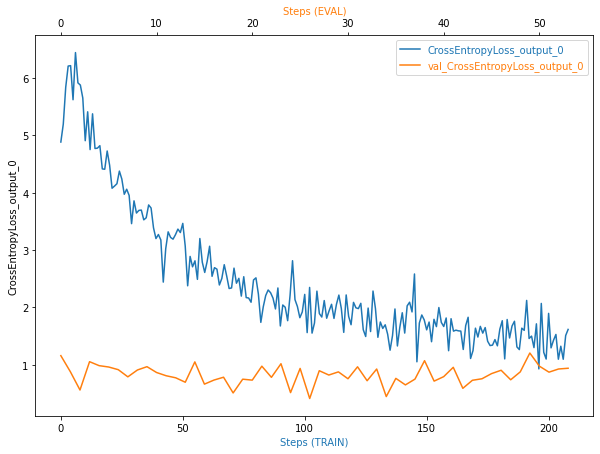

In [24]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

#### From the Graph:
* The validation loss is less than the Training loss therefore the validation dataset is easier than than the Training Dataset.
* The Training Loss is noisy, we can choose larger batch size

#### If the plot was erronous:
* More data
* Smaller model

In [25]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [26]:
! aws s3 ls {rule_output_path} --recursive

2023-09-14 09:19:59     381692 Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-09-14 09:19:59     229718 Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-09-14 09:19:54        192 Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-09-14 09:19:54        200 Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-09-14 09:19:54       2096 Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-09-14 09:19:54        127 Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease

In [27]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-650457939524/Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-650457939524/Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-650457939524/Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-650457939524/Image-classification-Project-debugging-2023-09-14-09-08-58-974/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/p

In [28]:
import os
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [30]:

predictor=estimator.deploy(
    initial_instance_count=1, instance_type="ml.t2.medium"
)

--------!

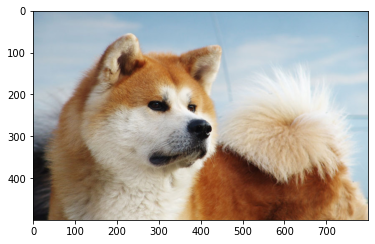

In [31]:

image = plt.imread("dogImages/test/004.Akita/Akita_00263.jpg")
plt.imshow(image)
plt.show()

In [32]:

import requests
from PIL import Image
import io
import torchvision.transforms as T

cwd = os.getcwd()
path = os.path.join(cwd, "dogImages/test/004.Akita/Akita_00263.jpg")
pil_img = Image.open(path)

# transforms
preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

image = preprocess(pil_img).unsqueeze(0)
image.shape

[2023-09-14 09:33:34.813 pytorch-1-10-cpu-py38-ml-t3-xlarge-f5e06a4150b004b1840ab9481805:5762 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


torch.Size([1, 3, 224, 224])

In [33]:
response = predictor.predict(image)

In [34]:
print(response)
print(f'lenght of response : {len(response[0])}')

[[-10.83315659  -8.94706059  -7.31158543  -0.43028134  -2.94664264
   -6.08704138  -7.73364449  -7.58654737  -8.42195702  -6.10238743
   -6.26779079  -7.36892366  -7.01372051  -3.60990429  -8.91897106
   -7.17713881  -9.92777634  -8.50745583  -7.10656929  -6.92352629
   -8.78148174  -7.79113626  -6.23944807  -4.65002823 -10.28417873
  -10.09421062  -8.70650387  -9.30662823  -8.5496254   -7.67568207
   -7.89393234  -8.64361     -7.6623292   -9.56678581 -11.45562458
  -10.15847778  -8.37324047  -7.68581247  -8.45086479  -7.47584057
   -9.7620163   -8.39353085  -4.92974186  -8.41406059  -5.68044281
   -8.2339468   -8.42993355  -7.12943316  -6.32825518  -7.58087969
   -3.29441977  -8.75701141  -7.13642311  -7.59862328  -8.7711916
   -9.07316875  -8.99063206  -8.8572731  -10.46639824  -9.77499294
   -9.63615799  -8.70402622  -8.68205833 -10.16602421  -9.04795361
  -12.48388195  -3.08836055  -9.59988213  -7.35499048  -9.08595467
   -8.72303963 -10.98805618  -9.14780807 -11.81765175 -10.04130